EPITA 2022 MLRF practice_04-01_BoVW v2022-05-20_185532 by Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice 04 part 01: Bag of Visual Words search engine

We will demonstrate how to use this classical technique to build a global descriptor from local descriptors.

In this session, you will learn how to produce results like the ones displayed below (left column: queries, other columns: responses to query in the same row).

![Sample output](img/practice_04/sample_results.jpg)


We will proceed in 9 steps:

1. Sample some descriptors for codebook learning
2. Learn normalisation parameters for descriptors (mean and eigenvectors)
3. Use k-Means to learn a codebook
4. Compute the BoVW vector for each image
5. Setup a nearest neighbors search structure
6. Evaluate our approach using mean average precision
7. Display some results
8. Compute the best results for the test queries
9. Export the results for the test queries (and submit them for grading).


## Resources
The resources for this session are distributed as a separate archive.
Here is a summary of the files we provide:
- `jpg/*.jpg`: 1491 images;
- `thumbs/*.jpg`: image thumbnails for fast display;
- `siftgeo/*.siftgeo`: associated pre-computed SIFT descriptors for each image;
- `gt_student.json`: a partial ground truth to enable a partial evaluation of the retrieval;
- `queries_for_grading.json`: a list of queries for which you need to submit your results.


## Ground truth format
The ground truth file is a JSON file. Here is an except:
```json
{
 "90314": [
  "90989",
  "91259"
 ],
 "90376": [
  "90674"
 ],
 ...
}
```
It contains a dictionary which associates to each query the list of relevant elements.
Every value is a string representing an image identifier, ie the part of the image or descriptor file without extension.

Example: `"90314"` is the identifier
of the image `jpgs/90314.jpg`
with descriptors available at `siftgeo/90314.siftgeo`
and its thumbnail is `thumbs/90314.jpg`.

Looking at the previous excerpt, we can see that the query `90314` has two relevant results: `90989` and `91259`. 


## Local descriptors
We provide precomputed SIFT descriptors to save you time.
We also provide a commodity function to help you load them (see below).

## 0. Import module, load resources

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
import os

In [2]:
# FIXME setup the resources location
PATH_TO_RESOURCES = "./dataset"

np.random.seed(42)

## Code to read descriptors
We provide you with the `siftgeo_read_desc(path)` function which reads the list of descriptors stored in a `.siftgeo` file.

In [3]:
SIFTGEO_DTYPE = np.dtype([
    ("x", "<f4"),
    ("y", "<f4"),
    ("scale", "<f4"),
    ("angle", "<f4"),
    ("mi11", "<f4"),
    ("mi12", "<f4"),
    ("mi21", "<f4"),
    ("mi22", "<f4"),
    ("cornerness", "<f4"),
    ("desdim", "<i4"),
    ("component", "<u1", 128)
])

def siftgeo_read_full(path):
    return np.fromfile(path, dtype=SIFTGEO_DTYPE)

def siftgeo_read_desc(path):
    desc = siftgeo_read_full(path)["component"]
    if desc.size == 0: 
        desc = np.zeros((0, 128), dtype = 'uint8')
    return desc

## Some of utility listings
Again, to save you time, here are some useful lists and mappings:
- `IMG_NAMES_FULL`: list of all full images paths
- `IMG_IDS`: list of image ids (filename without directories nor extension)
- `imgid_to_index`: a mapping from image ids (like `'90000'`, `'90001'`, `'90002'` or `'90003'` — note the quotes indicating string types) to an absolute index in the image list (like `0`, `1`, `2` or `3` — integers). **This will be useful to convert between image paths and rows in the global index.**

In [4]:
IMG_NAMES_FULL = !ls $PATH_TO_RESOURCES/thumbs/*.jpg | sort
len(IMG_NAMES_FULL), IMG_NAMES_FULL[:5]

(1491,
 ['./dataset/thumbs/90000.jpg',
  './dataset/thumbs/90001.jpg',
  './dataset/thumbs/90002.jpg',
  './dataset/thumbs/90003.jpg',
  './dataset/thumbs/90004.jpg'])

In [5]:
IMG_IDS = [p.split('/')[-1][:-4] for p in IMG_NAMES_FULL]
len(IMG_IDS), IMG_IDS[:5]

(1491, ['90000', '90001', '90002', '90003', '90004'])

In [6]:
# imgid_to_index: str             --> int
#                 image base name |-> rank of the content associated to this image in our various lists
imgid_to_index = {imgid: ii for ii, imgid in enumerate(IMG_IDS)}

# 1. Sample some descriptors for codebook learning
Because RAM is not that cheap, loading all descriptors in RAM and fitting a k-Means on them would require very complex implementation not available on our regular libraries.

We will select some images and load the descriptors for those images.

### 1.1 Load descriptors

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Randomly select 100 siftgeo files and load the descriptors from them. We will call those descriptors `train_desc`.**
    
*Hint: you can reuse what you did to select random RGB triplets (pixels) in `practice_02-01_color-histogram.ipynb`.*
</div>

In [7]:
# TODO sample some images
NB_SAMPLE = 100
sample_images = np.random.choice(IMG_IDS, replace=False, size=NB_SAMPLE)
sample_images

array(['90943', '90297', '90271', '91043', '90420', '91102', '90427',
       '91394', '90231', '91160', '90322', '90940', '91276', '90636',
       '91340', '91075', '90560', '90585', '91155', '91146', '90309',
       '90342', '90626', '90478', '91444', '90601', '90203', '91383',
       '90428', '90712', '90070', '90809', '91005', '90529', '90869',
       '91392', '91304', '90743', '91458', '91006', '90051', '90184',
       '90067', '90423', '90535', '91217', '90168', '90124', '90918',
       '91316', '90076', '90306', '90049', '90289', '90958', '90405',
       '90270', '91161', '90361', '90691', '90485', '91245', '90244',
       '90429', '90730', '90764', '91374', '91061', '90909', '90621',
       '90123', '91384', '91200', '91358', '90430', '90615', '90886',
       '91424', '90141', '90029', '90678', '90240', '90303', '90065',
       '90899', '90220', '90704', '91465', '90554', '91389', '91157',
       '90660', '90471', '90864', '90755', '91259', '91454', '90944',
       '91317', '912

In [8]:
# TODO load (all) the descriptors for those images
# train_desc = []
# for imid in sample_images:
#     ...
#    load the descriptors
#    append them in a list

def get_desc_from_imid(imid: str) -> np.array:
    im_path = f"{PATH_TO_RESOURCES}/siftgeo/{imid}.siftgeo"
    return siftgeo_read_desc(im_path)

train_desc = [get_desc_from_imid(imid) for imid in sample_images]
train_desc[0].shape

(26, 128)

In [9]:
# Let us look at the list of numpy arrays we just created
print(f"We loaded the descriptors of {len(train_desc)} images.")
for ii in range(3):
    print(f"For image {ii}, we read {train_desc[ii].shape[0]} descriptors."
          f" Each of them has {train_desc[ii].shape[1]} components stored as {train_desc[ii].dtype}")

We loaded the descriptors of 100 images.
For image 0, we read 26 descriptors. Each of them has 128 components stored as uint8
For image 1, we read 4256 descriptors. Each of them has 128 components stored as uint8
For image 2, we read 376 descriptors. Each of them has 128 components stored as uint8


This should print something like:
```
We loaded the descriptors of 100 images.
For image 0, we read 514 descriptors. Each of them has 128 components stored as uint8
For image 1, we read 5146 descriptors. Each of them has 128 components stored as uint8
For image 2, we read 1208 descriptors. Each of them has 128 components stored as uint8
```

You should take some time to anwser the following questions:

1. Do you have the same number of descriptors than in the previous text for each image?
2. Is there the same number of descriptors for all images?
3. What is the size of a single SIFT descriptor (in bytes)?

### 1.2 Prepare those descriptors for training
For those descriptors to be helpful, we need them to be staked in a big single array of shape `(num_desc, desc_len)` where `desc_len` is the length of a single descriptor — here 128 because SIFT decriptors are vectors of 128 integers.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Turn your list of arrays of descriptors in a big single array. Its shape should be something like `(314302, 128)`.**

Hint: look as `numpy.*stack` functions.
</div>

In [10]:
# TODO stack all you descriptors into one big array
train_desc = np.vstack(train_desc) # FIXME
train_desc.shape, train_desc.dtype

((288622, 128), dtype('uint8'))

Finally, we convert this array to float32 elements to avoid normalization issues.

In [11]:
train_desc = train_desc.astype(np.float32)

## 2. Learn normalisation parameters for descriptors
Before learning a codebook, it is a good practice to:
- center the features;
- reduce their dimension using PCA.

**Warning**: We do NOT REDUCE (divide by the variance) the descriptors here because we want to keep the relative value of the variables. This is indeed the very purpose of histograms! **If you have time, you can provide a comparison with/without reduction in your report for extra point(s).**

**This is a first learning step!** Because we will compute a **mean** and **eigenvectors** on a **training set**, we need to **store those values** in order to be able to apply them to test elements later.

### 2.1 Centering descriptors

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute and store the mean of your descriptors, then center them.**
</div>

In [12]:
# TODO compute mean and center descriptors
train_mean = np.mean(train_desc, axis=0)
# train_desc = train_desc - train_mean

### 2.2 PCA
We will now compute the PCA parameters which will allow us to reduce the dimension of our descriptors from 128 floats to 64 floats, keeping as much information as possible.

In [13]:
# compute PCA matrix and keep only 64 dimensions
train_cov = np.dot(train_desc.T, train_desc)
eigvals, eigvecs = np.linalg.eig(train_cov)
perm = eigvals.argsort()                   # sort by increasing eigenvalue
pca_transform = eigvecs[:, perm[64:128]]   # eigenvectors for the 64 last eigenvalues
pca_transform.shape, pca_transform.dtype

((128, 64), dtype('float32'))

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Apply the PCA transformation to your descriptors.**

Hint: we expect to get a new `train_desc` array with the same number of rows, but only 64 columns (dimensions). You can use sklearn's preprocessing tools if you prefer.
</div>

In [14]:
# TODO
# perform the appropriate matrix multiplication to transform your descriptors
# train_desc = train_desc @ pca_transform

In [15]:
# Check the shape of your new descriptors: we expect a shape like (BIGNUMBER, 64)
train_desc.shape

(288622, 128)

## 3. Use k-Means to learn a codebook
We are now ready to learn a codebook using those centered and compact descriptors.
We will use exactly the same technique as the one we used to compute color histograms:
- first we fit a k-Means;
- then, using the centroids we found, we will project the descriptors and compute bag of features for each image.

In [16]:
from sklearn.cluster import KMeans, MiniBatchKMeans

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Fit a k-Means with 512 clusters on the training descriptors.**
</div>

In [17]:
# TODO fit a k-means (this should be fast; e.g. 5 secondes on a laptop with a gen 8 i7 CPU and 16 GB of RAM)
NB_CLUSTERS = 256
kmeans = MiniBatchKMeans(n_clusters=NB_CLUSTERS)
kmeans.fit(train_desc)

MiniBatchKMeans(n_clusters=256)

In [18]:
# let's check the shape of the cluster's centers
kmeans.cluster_centers_.shape

(256, 128)

We expect a shape of `(512, 64)` for cluster centers: we have 512 clusters in a 64-dimensional space.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**How do we call this set of cluster centers? They define the set of possible descriptor values we will use to build bag of visual words descriptors. Write down your answer.**
</div>

We call this set of cluster centers: the dictionary, the codebook or also the visual vocabulary.

## 4. Compute the BoVW vector for each image
Using the codebook we just learned, we will compute for each image its bag of features vector (histogram of projected descriptors).

It is almost exaclty like the color histogram we computed in practice session 2!
The **only** difference is that we have much more dimensions.

We will put those descriptors in a naive index made of a single NumPy array.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**For each image, compute its BoVW vector.**
</div>

**Beware:**
- in a few images no descriptor was extracted so you need to skip those elements
- you need to apply the same preprocessings than the ones you applied to training descriptors (center, dimension reduction)


### L1 Normalisation

In [19]:
%%script true # Skip execution


# TODO index all images

# Here is our very simple index (keep it initialized like this)
global_image_descr = np.zeros((len(IMG_IDS), kmeans.n_clusters), dtype=np.float32)

for ii, imgid in enumerate(IMG_IDS):
    # print("Indexing %s" % (imgid,))
    # read the descriptors
    desc = get_desc_from_imid(imgid).astype(np.float32)  # FIXME
    
    # handle case where no descriptor is available
    if desc.shape[0] == 0:
        # let the descriptor be 0 for all values
        # note that this is bad and the element should be dropped from the index
        # but here we keep it to preserve image vs desc ids (no worries, it will work)
        print("WARNING: zero descriptor for %s" % (imgid,))
        continue
    
    # apply the same preprocessing as for training descriptors
    # desc -= train_mean   # FIXME
    # desc  = desc @ pca_transform

    # get cluster ids
    cluster_ids = kmeans.predict(desc)  # FIXME
    
    # compute histogram (do not forget to normalize by the number of descriptors)
    descr_hist = np.bincount(cluster_ids, minlength=NB_CLUSTERS) / desc.shape[0] # FIXME
    
    # update the index
    global_image_descr[ii] = descr_hist   # FIXME (just uncomment)
    
print("Indexing complete.")
global_image_descr.shape, global_image_descr.dtype

### TFIDF Normalisation

In [20]:
%%script true # Skip execution


# TODO index all images

# Here is our very simple index (keep it initialized like this)
word_occurences_per_image = np.zeros((len(IMG_IDS), kmeans.n_clusters), dtype=np.float32)
nb_words_per_image = np.ones((len(IMG_IDS), kmeans.n_clusters), dtype=np.int32)

for ii, imgid in enumerate(IMG_IDS):
    # print("Indexing %s" % (imgid,))
    # read the descriptors
    desc = get_desc_from_imid(imgid).astype(np.float32)  # FIXME
    
    # handle case where no descriptor is available
    if desc.shape[0] == 0:
        # let the descriptor be 0 for all values
        # note that this is bad and the element should be dropped from the index
        # but here we keep it to preserve image vs desc ids (no worries, it will work)
        print("WARNING: zero descriptor for %s" % (imgid,))
        continue
    
    # apply the same preprocessing as for training descriptors
    # desc -= train_mean   # FIXME
    # desc  = desc @ pca_transform

    # get cluster ids
    cluster_ids = kmeans.predict(desc)  # FIXME
    
    # compute histogram (do not forget to normalize by the number of descriptors)
    descr_hist = np.bincount(cluster_ids, minlength=NB_CLUSTERS) # FIXME
    nb_words_per_image[ii] = desc.shape[0] # FIXME
    
    # update the index
    word_occurences_per_image[ii] = descr_hist   # FIXME (just uncomment)
    
log_coeff = np.log(len(IMG_IDS) / np.sum(word_occurences_per_image, axis=0)) # FIXME
global_image_descr = word_occurences_per_image / nb_words_per_image * log_coeff # FIXME
print("Indexing complete.")
global_image_descr.shape, global_image_descr.dtype

### VLAD

In [21]:
# %%script true # Skip execution


# TODO index all images

# Here is our very simple index (keep it initialized like this)
global_image_descr = np.zeros((len(IMG_IDS), kmeans.n_clusters * kmeans.cluster_centers_.shape[1]), dtype=np.float32)

for ii, imgid in enumerate(IMG_IDS):
    # print("Indexing %s" % (imgid,))
    # read the descriptors
    desc = get_desc_from_imid(imgid).astype(np.float32)  # FIXME
    
    # handle case where no descriptor is available
    if desc.shape[0] == 0:
        # let the descriptor be 0 for all values
        # note that this is bad and the element should be dropped from the index
        # but here we keep it to preserve image vs desc ids (no worries, it will work)
        print("WARNING: zero descriptor for %s" % (imgid,))
        continue
    
    # apply the same preprocessing as for training descriptors
    # desc -= train_mean   # FIXME
    # desc  = desc @ pca_transform

    # get cluster ids
    cluster_ids = kmeans.predict(desc)  # FIXME
    mean_shift_norm = np.zeros((kmeans.n_clusters, kmeans.cluster_centers_.shape[1]), dtype=np.float32) # FIXME
    
    for cluster_id in range(NB_CLUSTERS):
        if (not np.any(cluster_ids == cluster_id)):
            continue
        mean_shift = np.sum(desc[cluster_ids == cluster_id, :] - kmeans.cluster_centers_[cluster_id, :], axis=0)
        mean_shift_norm[cluster_id, :] = mean_shift #/ np.linalg.norm(mean_shift) # l2 normalisation
        
    # update the index
    global_image_descr[ii] = mean_shift_norm.flatten() / np.linalg.norm(mean_shift_norm)  # FIXME (just uncomment)
    
print("Indexing complete.")
global_image_descr.shape, global_image_descr.dtype

Indexing complete.


((1491, 32768), dtype('float32'))

In [22]:
pca_transform.shape

(128, 64)

## 5. Setup a nearest neighbors search structure
We will use a simple nearest neighbors implementation to test our approach.

In [23]:
from sklearn.neighbors import NearestNeighbors

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using scikit-learn's implementation of nearest neighbors, setup a search engine with a linear search strategy and an appropriate metric.**
</div>

In [24]:
# TODO setup search engine
search_engine = NearestNeighbors(algorithm="brute", metric="euclidean")

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now index you descriptors.**
</div>

In [25]:
# TODO index descriptors
search_engine.fit(global_image_descr);

## 6. Evaluate our approach using mean average precision
We can now evaluate the performance of our search engine using the available ground truth.

### 6.1 Load the ground truth
The ground truth is a simple dictionary mapping query ids to relevant image ids:
```json
{'90314': ['90989', '91259'],
 '90376': ['90674'],
 '90175': ['90512'],
 ...
}
```

In [26]:
import json

In [27]:
PATH_TO_GT = os.path.join(PATH_TO_RESOURCES, "gt_student.json")
gt_data = None
with open(PATH_TO_GT, 'r') as in_gt:
    gt_data = json.load(in_gt)

### 6.3 Select the descriptors of the query images

The annoying part is to convert between the indices of the elements in our index structure `global_image_descr` and the images ids which allow us to find files.

The upside is that reusing the precomputed descriptors avoids us the need for computing the BoVW vector for each query image.

We use the `imgid_to_index`, which helps us converting between image ids (filename without directory nor extension) and index value in the `global_image_descr` array, to recover the indices of the rows corresponding to the query images in `global_image_descr`.

Here is below some code you should run and try to understand.

In [28]:
# get the indices of the query images
query_imnos = [imgid_to_index[query_id] for query_id in gt_data.keys()]

In [29]:
len(query_imnos)

250

In [30]:
IMG_IDS[query_imnos[0]]

'90314'

In [31]:
gt_data[IMG_IDS[query_imnos[0]]]

['90989', '91259']

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Using `query_imnos`, you can now select the descriptors of the query images from the precomputed array `global_image_descr`.**
</div>

In [32]:
# TODO select the descriptors of the query images
query_vectors = global_image_descr[query_imnos]

### 6.4 Run the query

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Run a search query for all query images using our search engine. Ask for 9 neighbors because we want 8 real results and we will later remove the query from the list of results (we expect it the be the first result here, because our queries belong to our database for testing purposes).**
</div>

In [33]:
# TODO
# get the 9 (8 real) NNs for all query images
distances, results = search_engine.kneighbors(query_vectors, n_neighbors=9) # FIXME
results.shape

(250, 9)

We expect here a shape of `(250, 9)` for the results.

### 6.4 Evaluate the performance using mAP
The mean average precision is the mean of the AP computed for each query.
The AP is the area under the precision-recall curve.

For each query, we will therefore sum the areas of the trapezoids between each recall values.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Complete the code below to compute the mean average precision of our search engine on the training set.**

Hint: you should get a value much higher than what random results would produce ($0.001$ in our tests but you can simulate this yourself).
</div>

In [34]:
# TODO complete this code
aps = []  # list of average precisions for all queries
for qimno, qres in zip(query_imnos, results):
    qname = IMG_IDS[qimno]
#     print("query:", qname)
    # collect the positive results in the dataset
    # the positives have the same prefix as the query image
    positive_results = [imgid_to_index[img_id] for img_id in gt_data[IMG_IDS[qimno]]]
#     print("positive_results:", positive_results)
#     print("qres:", qres)
    #
    # ranks of positives. We skip the result #0, assumed to be the query image
    ranks = [i for i, res in enumerate(qres[1:]) if res in positive_results]
#     print("ranks:", ranks)
    #
    # accumulate trapezoids with this basis
    recall_step = 1.0 / len(positive_results)  # FIXME what is the size of a step?
    ap = 0
    for ntp, rank in enumerate(ranks):
        # ntp = nb of true positives so far
        # rank = nb of retrieved items so far
        # y-size on left side of trapezoid:
        precision_0 = ntp/float(rank) if rank > 0 else 1.0
        # y-size on right side of trapezoid:
        precision_1 = (ntp + 1) / float(rank + 1)
        square_area = (precision_1 - precision_0) * recall_step / 2 # FIXME
        triangle_area = precision_0 * recall_step # FIXME
        ap += square_area + triangle_area  # FIXME what is the area under the PR curve?
    # print("query %s, AP = %.3f" % (qname, ap))
    aps.append(ap)

print(f"mean AP = {np.mean(aps):.3f}")  # FIXME mean average precision

mean AP = 0.168


## 7. Display some results
We provide you with some code to display query results.

<Figure size 432x288 with 0 Axes>

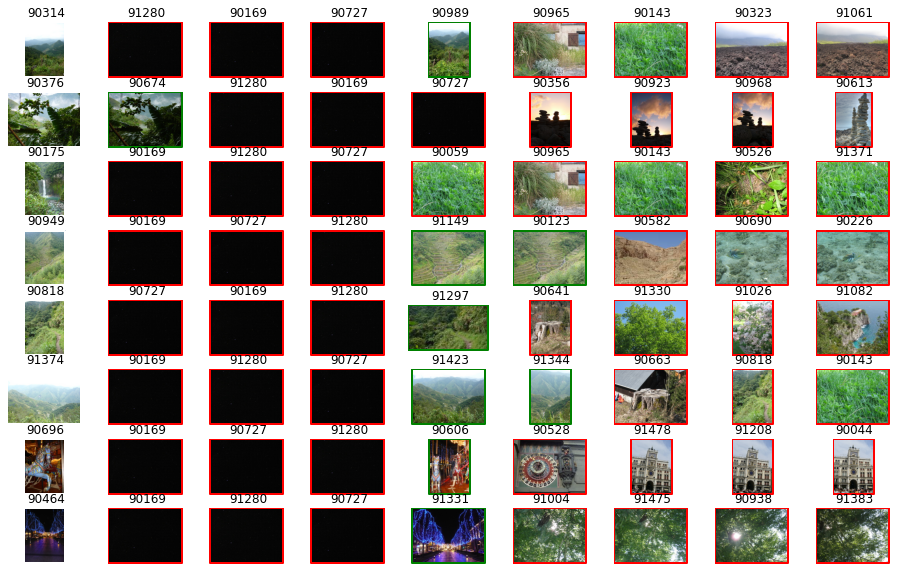

In [35]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

nrow = 8   # number of query images to show
nres = 8   # number of results per query

def show_image(imno, frame_color):
    im = imread(os.path.join(PATH_TO_RESOURCES, "thumbs", "%s.jpg" % IMG_IDS[imno]))
    plt.imshow(im)
    h, w = im.shape[:2]
    plt.plot([0, 0, w, w, 0], [0, h, h, 0, 0], frame_color, linewidth = 2)
    plt.axis('off')

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(16,10))
no = 1  # index current of subfigure
for qno in range(nrow):
    plt.subplot(nrow, nres + 1, no); no += 1
    # show query image with white outline
    qimno = query_imnos[qno]
    show_image(qimno, 'w')
    plt.title(IMG_IDS[qimno])
    for res_rank, qres in enumerate(results[qno, 1:nres+1]): # 1:nres+1 => skip query from results
        plt.subplot(nrow, nres + 1, no); no += 1
        # use image name to determine if it is a TP or FP result
        is_ok = IMG_IDS[qres] in gt_data[IMG_IDS[qimno]]
        show_image(qres, 'g' if is_ok else 'r')
#         plt.title("%0.2f" % (distances[qno,res_rank]))
        plt.title(IMG_IDS[qres])

plt.show();

## 8. Compute the best results for the test queries
You are now ready to process the test data for the grading.

We provide you with a set of query ids, and you must produce the list of most releveant results for each.

In [36]:
test_queries = None
with open(os.path.join(PATH_TO_RESOURCES, "queries_for_grading.json")) as qin:
    test_queries = json.load(qin)
test_queries[:10], len(test_queries)

(['91401',
  '91274',
  '90136',
  '91071',
  '91221',
  '90274',
  '90240',
  '90662',
  '90169',
  '90751'],
 250)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**For each query, compute the list of best results.**
</div>

In [37]:
# TODO everything

test_query_imnos = [imgid_to_index[query_id] for query_id in test_queries]
test_query_vectors = global_image_descr[test_query_imnos]
test_distances, test_results = search_engine.kneighbors(test_query_vectors, n_neighbors=9)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Display your results to control them visually. Make sure you really perform this step because the train and test sets have the same size here, and it is easy to get confused and submit the wrong set!**
</div>

<Figure size 432x288 with 0 Axes>

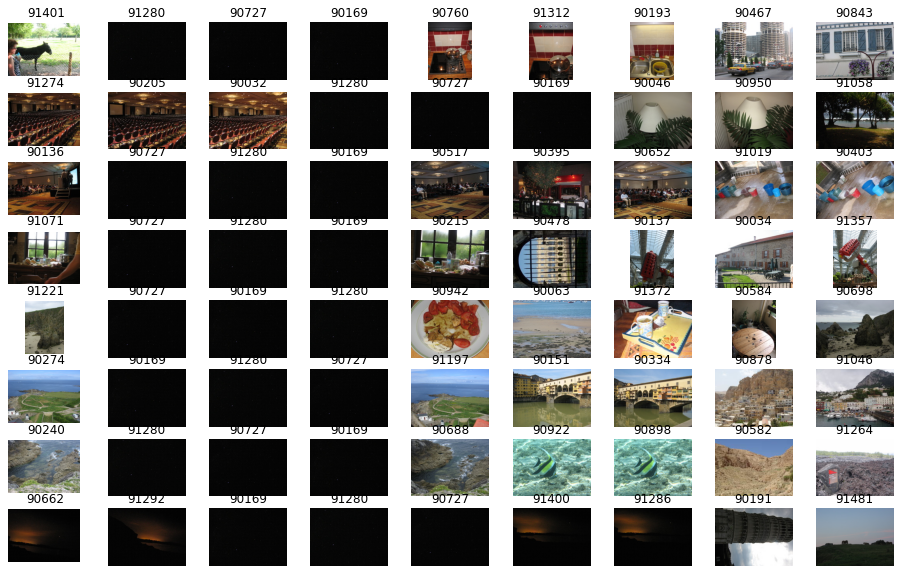

In [38]:
# TODO

# reduce the margins
plt.subplots_adjust(wspace = 0, hspace = 0,
                    top = 0.99, bottom = 0.01, left = 0.01, right = 0.99)

plt.figure(figsize=(16,10))
no = 1  # index current of subfigure
for qno in range(nrow):
    plt.subplot(nrow, nres + 1, no); no += 1
    # show query image with white outline
    qimno = test_query_imnos[qno]
    show_image(qimno, 'w')
    plt.title(IMG_IDS[qimno])
    for res_rank, qres in enumerate(test_results[qno, 1:nres+1]): # 1:nres+1 => skip query from results
        plt.subplot(nrow, nres + 1, no); no += 1
        
        im = imread(os.path.join(PATH_TO_RESOURCES, "thumbs", "%s.jpg" % IMG_IDS[qres]))
        plt.imshow(im)
        plt.axis('off')
        plt.title(IMG_IDS[qres])

plt.show();

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="warning" src='img/warning.png' style='float: left; margin-right: 20px'>

**The train and test set have the same size! Make sure you submit results for the test set and not for the train set.**
</div>

## 9. Export the results for the test queries

Here is some code to export your results in the appropriate format.

**Do not forget to submit them!**

In [39]:
results = {query_id: [IMG_IDS[ri] for ri in results_ids[1:]]
           for query_id,results_ids in zip(test_queries, test_results)}
results;

In [40]:
EXPORT_PATH = "results.json"

In [41]:
with open(EXPORT_PATH, 'w') as outres:
    json.dump(results, outres, indent=1)
!head $EXPORT_PATH

{
 "91401": [
  "91280",
  "90727",
  "90169",
  "90760",
  "91312",
  "90193",
  "90467",
  "90843"


# Experimentation
## Number of samples ?
Experimentation have been undergone with 100, 500 and all images as samples for training.
Unfortunatly, no significant improvement of the mAP have been observed. We will therefore keep the easiest to compute, a.k.a 100.

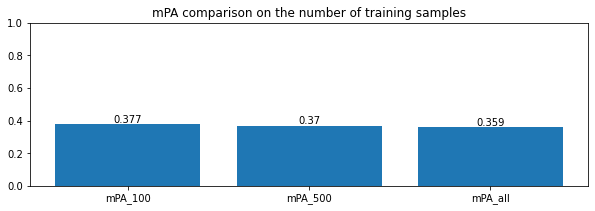

In [42]:
# Those values were obtained through experimentation with the above cells.
# They are hardcoded to prevent intensive computation and easier readability through the notebook.
# You can still easily reproduce those results by modifying the above cells to the tested values.
# A seed is used to ensure the reproductability.
mPA_100 = 0.377
mPA_500 = 0.370
mPA_all = 0.359

_, ax = plt.subplots(figsize=(10,3))

x = range(3)
bars = ax.bar(x, height=[mPA_100, mPA_500, mPA_all], bottom=(0))
ax.set_xticks(x, ['mPA_100', 'mPA_500', 'mPA_all'])
ax.set_ylim(top=1)
ax.set_title("mPA comparison on the number of training samples")
ax.bar_label(bars);

## Reduction and PCA ?
In the same way, experimentation have been undergone with this pipeline (`mPA_baseline`) and without mean-reduction (`mPA_no_reduc`), without PCA (`mPA_no_PCA`) and without both (`mPA_nothing`). Unfortunatly, no significant improvement of the mAP have been observed throughout those experimentation. Though, it is worth noting that the execution time can be significantly reduced by removing the PCA and the mean-reduction. We will therefore keep this last configuration for latter experiment.

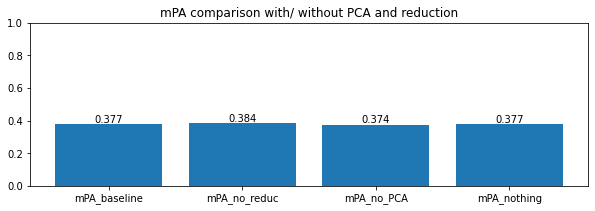

In [43]:
mPA_baseline = 0.377
mPA_no_reduc = 0.384
mPA_no_PCA   = 0.374
mPA_nothing  = 0.377

_, ax = plt.subplots(figsize=(10,3))

x = range(4)
bars = ax.bar(x, height=[mPA_baseline, mPA_no_reduc, mPA_no_PCA, mPA_nothing], bottom=(0))
ax.set_xticks(x, ['mPA_baseline', 'mPA_no_reduc', 'mPA_no_PCA', 'mPA_nothing'])
ax.set_ylim(top=1)
ax.set_title("mPA comparison with/ without PCA and reduction")
ax.bar_label(bars);

## Number of Visual Words ?
It is often said that the bigger the vocabulary the better the results. Let's test this saying.\
The experimentations seems to show that it is true until a certain point. The optimal number of words for this pipeline seems to lie between 128 and 512.

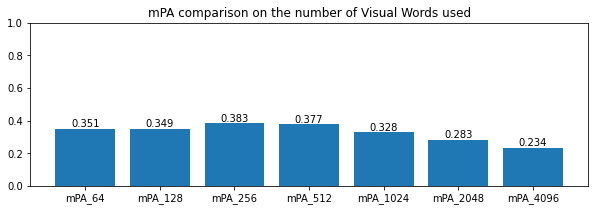

In [44]:
mPA_64   = 0.351
mPA_128  = 0.349
mPA_256  = 0.383
mPA_512  = 0.377
mPA_1024 = 0.328
mPA_2048 = 0.283
mPA_4096 = 0.234

_, ax = plt.subplots(figsize=(10,3))

x = range(7)
bars = ax.bar(x, height=[mPA_64, mPA_128, mPA_256, mPA_512, mPA_1024, mPA_2048, mPA_4096], bottom=(0))
ax.set_xticks(x, ['mPA_64', 'mPA_128', 'mPA_256', 'mPA_512', 'mPA_1024', 'mPA_2048', 'mPA_4096'])
ax.set_ylim(top=1)
ax.set_title("mPA comparison on the number of Visual Words used")
ax.bar_label(bars);

## Visual Words Normalisation
Until now, we used a L1 normalisation on Visual Words after their encoding. But other normalisations are possible, as for example: TFIDF normalisation. The goal of TFIDF is the give more importance to rare words than to frequent ones. Let's see how it impacts the performance of our pipeline.\
Unfortunatly no significant modification can be observed...

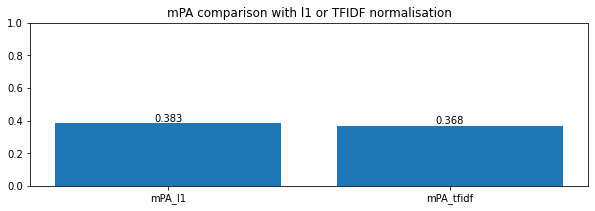

In [45]:
mPA_l1 = 0.383
mPA_tfidf = 0.368

_, ax = plt.subplots(figsize=(10,3))

x = range(2)
bars = ax.bar(x, height=[mPA_l1, mPA_tfidf], bottom=(0))
ax.set_xticks(x, ['mPA_l1', 'mPA_tfidf'])
ax.set_ylim(top=1)
ax.set_title("mPA comparison with l1 or TFIDF normalisation")
ax.bar_label(bars);